In [1]:
%matplotlib inline
import numpy as np
import torch
from matplotlib import pyplot as plt
torch.set_printoptions(edgeitems=2, linewidth=75)

# Gathering some data

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

# Visualizing the data

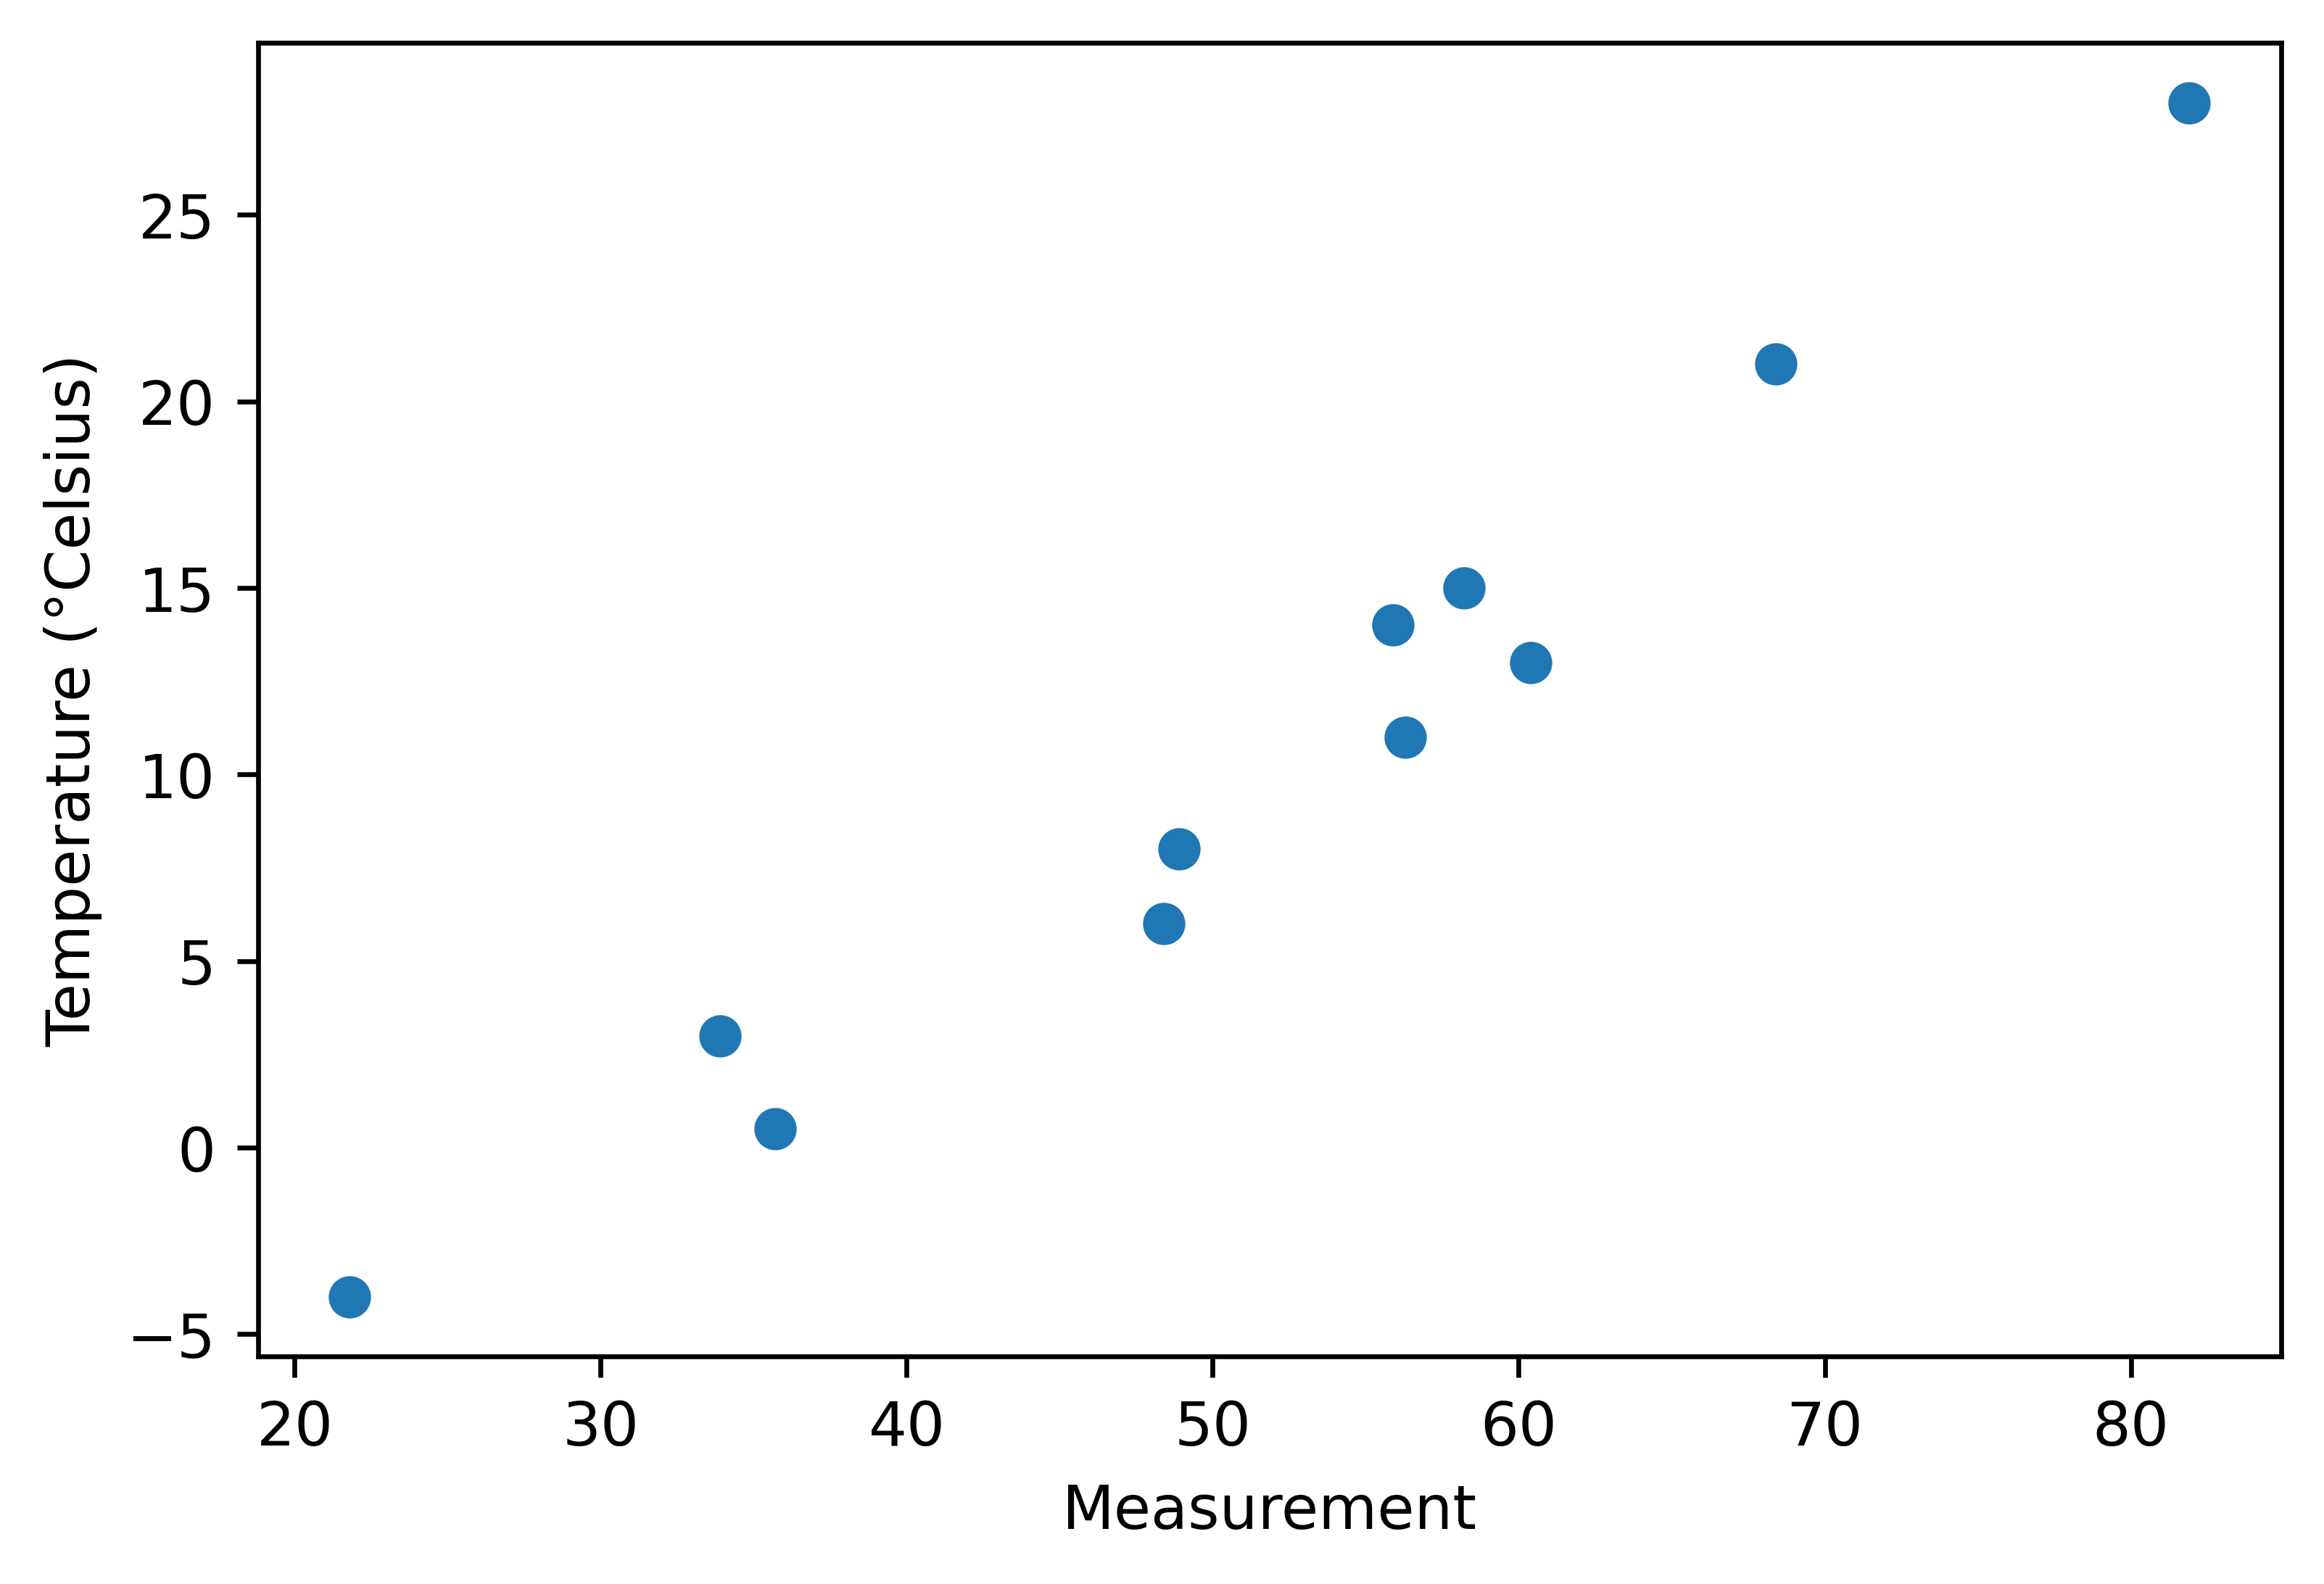

In [3]:
fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

#plt.savefig("temp_data_plot.png", format="png")

# Building the model

In [4]:
def model(t_u, w, b):
    return w * t_u + b

In [5]:
def loss_fn(t_p, t_c):
    return torch.mean((t_p - t_c)**2)

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

In [8]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)

print(f'shape x: {x.shape}, shape y: {y.shape}')
print(f"z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shape x: torch.Size([]), shape y: torch.Size([3, 1])
z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


# Down along the gradient

## Decreasing loss

In [9]:
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w+delta, b), t_c) - loss_fn(model(t_u, w-delta, b), t_c)) / (2.0 * delta)
loss_rate_of_change_w

tensor(4517.2979)

In [10]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w
w

tensor(-44.1730)

In [11]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
b

tensor(46.0250)

## Get analytical

In [12]:
def dloss_fn(t_p, t_c):
    return 2.0 * (t_p - t_c) / t_p.size(0)

In [13]:
def dmodel_dw(t_u, w, b):
    return t_u

In [14]:
def dmodel_db(t_u, w, b):
    return 1.0

In [32]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

## Iterating to fit the model

In [33]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000, 7000, 8000, 10000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [34]:
training_loop(n_epochs=100, learning_rate=1e-4, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122])
...
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022669
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

## Normalizing inputs

In [35]:
t_un = 0.1 * t_u

In [36]:
training_loop(n_epochs=100, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_un, t_c=t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [41]:
params = training_loop(n_epochs=10000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_un, t_c=t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])
Epoch 7000, Loss 2.927645
    Params: tensor([  5.3676, -

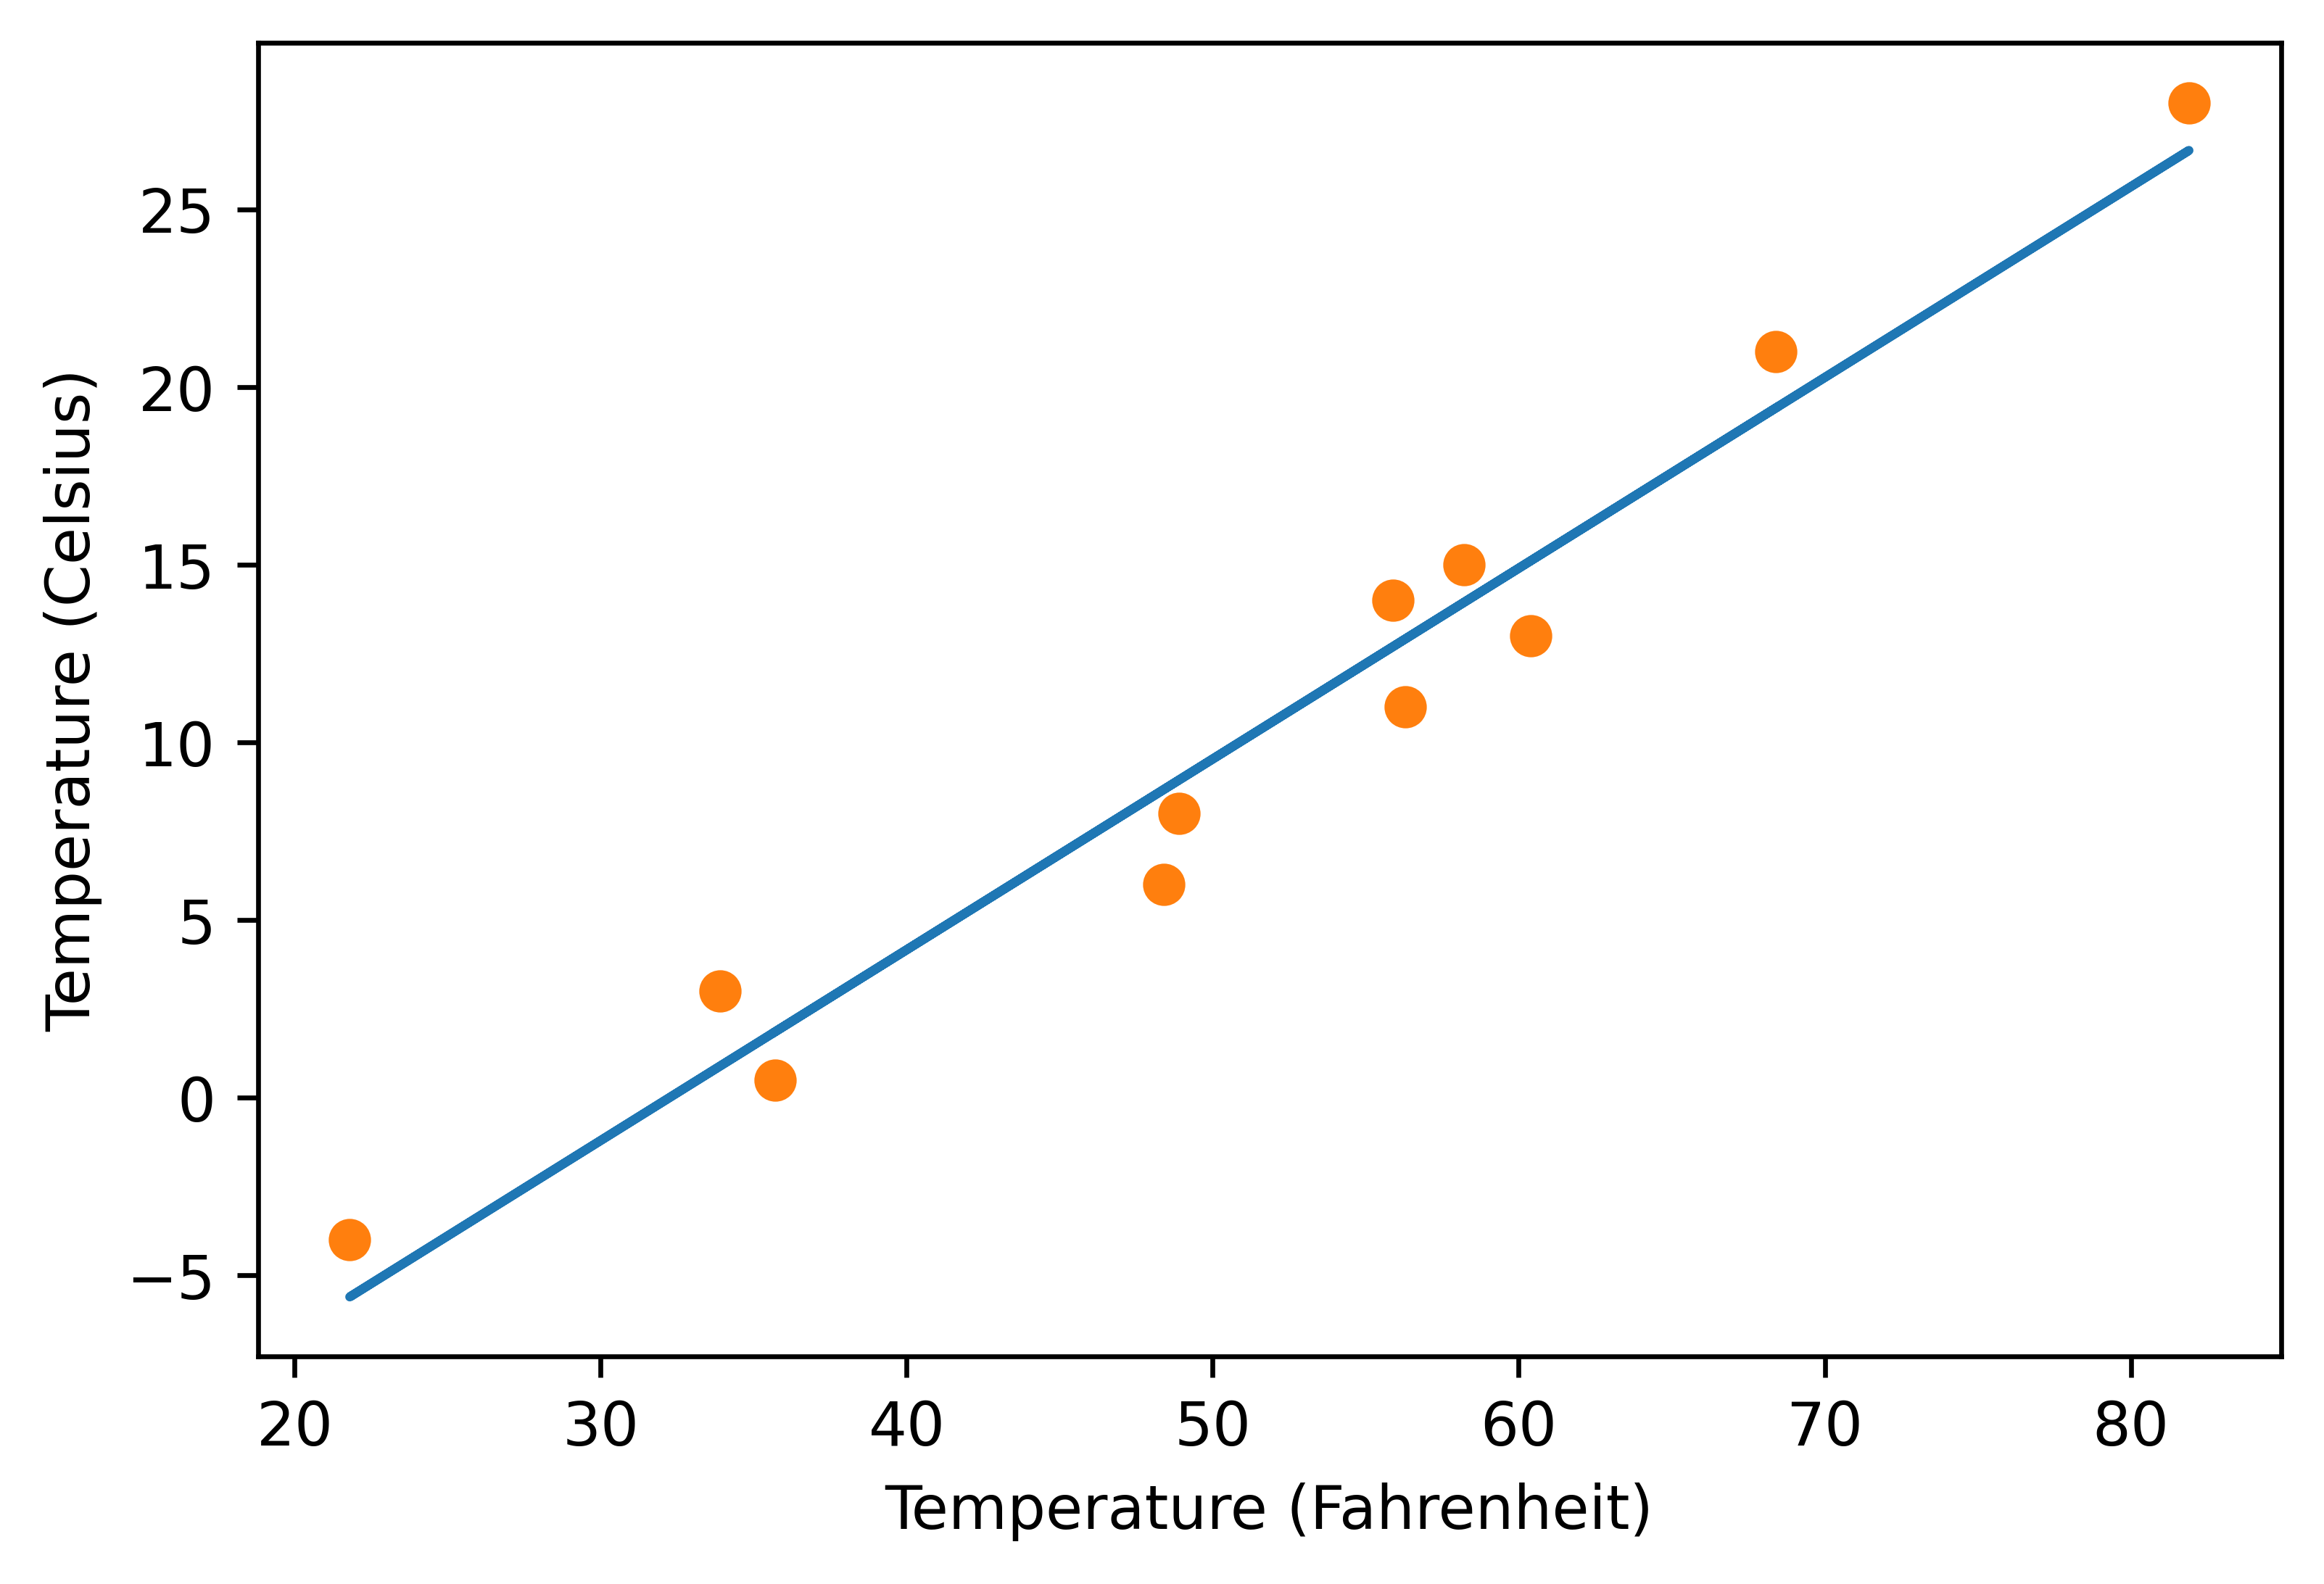

In [42]:
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Temperature (Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

# PyTorch's autograd: Backpropagating all things

## Computing the gradient automatically

In [44]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [46]:
params.grad is None

True

In [48]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([9034.5938,  165.2000])

In [50]:
if params.grad is not None:
    params.grad.zero_()

In [51]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss}')
            
    return params

In [52]:
training_loop(n_epochs=5000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0], requires_grad=True), t_u = t_un, t_c=t_c)

Epoch 500, Loss 7.8601155281066895
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.9576973915100098
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286482334136963
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.92765212059021
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers

In [53]:
import torch.optim as optim

In [54]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

In [55]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [56]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [63]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [64]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss}')
    
    return params

In [66]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs=5000, optimizer=optimizer, params=params, t_u=t_un, t_c=t_c)

Epoch 500, Loss 7.8601179122924805
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.9576973915100098
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286482334136963
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.927680253982544
Epoch 4500, Loss 2.9276506900787354
Epoch 5000, Loss 2.927647590637207


tensor([  5.3671, -17.3012], requires_grad=True)

In [68]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=5000, optimizer=optimizer, params=params, t_u=t_u, t_c=t_c)

Epoch 500, Loss 7.612902641296387
Epoch 1000, Loss 3.086700201034546
Epoch 1500, Loss 2.9285781383514404
Epoch 2000, Loss 2.9276459217071533
Epoch 2500, Loss 2.9276463985443115
Epoch 3000, Loss 2.927644968032837
Epoch 3500, Loss 2.9276468753814697
Epoch 4000, Loss 2.927644968032837
Epoch 4500, Loss 2.927645683288574
Epoch 5000, Loss 2.927645683288574


tensor([  0.5368, -17.3048], requires_grad=True)

## Training, validation, and overfiting

In [78]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8,  4,  3,  6, 10,  5,  7,  1,  0]), tensor([9, 2]))

In [79]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [80]:
def training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
              
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}')
    
    return params

In [81]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=5000, optimizer=optimizer, params=params, train_t_u=train_t_u, train_t_c=train_t_c, val_t_u=val_t_u, val_t_c=val_t_c)

Epoch 1, Training loss 1698.8590, Validation loss 2056.5002
Epoch 2, Training loss 1287.2949, Validation loss 1546.0933
Epoch 3, Training loss 936.0118, Validation loss 1110.9133
Epoch 500, Training loss 6.8831, Validation loss 2.2864
Epoch 1000, Training loss 2.9946, Validation loss 2.9126
Epoch 1500, Training loss 2.9340, Validation loss 3.0146
Epoch 2000, Training loss 2.9339, Validation loss 3.0190
Epoch 2500, Training loss 2.9339, Validation loss 3.0191
Epoch 3000, Training loss 2.9339, Validation loss 3.0191
Epoch 3500, Training loss 2.9339, Validation loss 3.0191
Epoch 4000, Training loss 2.9339, Validation loss 3.0191
Epoch 4500, Training loss 2.9339, Validation loss 3.0191
Epoch 5000, Training loss 2.9339, Validation loss 3.0191


tensor([  0.5417, -17.4325], requires_grad=True)

## Autograds nits and switching it off

In [85]:
def training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}')
    
    return params

In [86]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=1, optimizer=optimizer, params=params, train_t_u=train_t_u, train_t_c=train_t_c, val_t_u=val_t_u, val_t_c=val_t_c)

Epoch 1, Training loss 1698.8590, Validation loss 2056.5002


tensor([ 0.9000, -0.1000], requires_grad=True)

In [95]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

In [102]:
def training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_loss = calc_forward(train_t_u, train_t_c, True)
        
        val_loss = calc_forward(val_t_u, val_t_c, False)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}')
    
    return params

In [101]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=1, optimizer=optimizer, params=params, train_t_u=train_t_u, train_t_c=train_t_c, val_t_u=val_t_u, val_t_c=val_t_c)

True
False
Epoch 1, Training loss 1698.8590, Validation loss 2056.5002


tensor([ 0.9000, -0.1000], requires_grad=True)